In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization


In [ ]:
tessData = '/content/drive/MyDrive/Tess'


This code recursively traverses a directory (tessData), collects file paths and their corresponding labels (extracted from filenames), storing them in lists, until it reaches 2800 files, and then prints "Dataset is Loaded".

In [ ]:
paths = []
labels = []
for dirname, _, filenames in os.walk(tessData):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())
    if len(paths) == 2800:
        break

print('Dataset is Loaded')

Dataset is Loaded


This code snippet creates a Pandas DataFrame (`df`) with two columns: 'speech' containing file paths and 'label' containing corresponding labels. It then encodes the labels numerically using `LabelEncoder` from scikit-learn and adds the encoded labels as a new column 'label_encoded'. Finally, it visualizes the distribution of labels using a count plot from Seaborn, showing the frequency of each label in the dataset.

<Axes: xlabel='label', ylabel='count'>

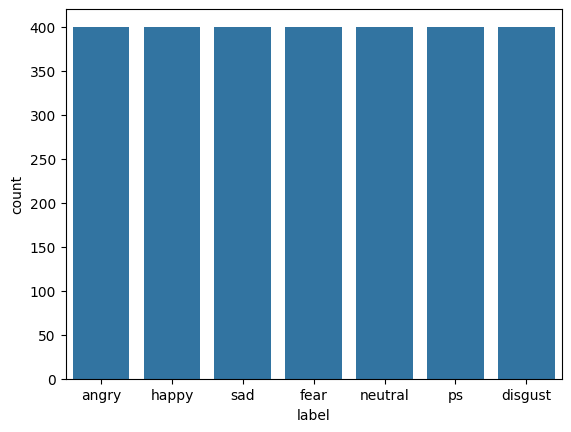

In [ ]:
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels

# encoding
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

sns.countplot(data=df, x='label')

This code performs several tasks related to processing audio data for machine learning tasks:

1. **Defining a Function to Extract MFCC Features (`extract_mfcc`)**:
   - The function `extract_mfcc` takes a filename as input.
   - It uses librosa library to load the audio file (`filename`) with a duration of 3 seconds starting from an offset of 0.5 seconds.
   - It computes the Mel-frequency cepstral coefficients (MFCCs) of the audio signal using `librosa.feature.mfcc()`.
   - The `n_mfcc` parameter specifies the number of MFCCs to return, which is set to 40 here.
   - It takes the mean of the MFCCs along the time axis (`axis=0`).
   - Finally, it returns the MFCC features.

2. **Applying `extract_mfcc` Function to Each File Path**:
   - The `apply()` function is used on the 'speech' column of the DataFrame (`df`) to apply the `extract_mfcc` function to each file path.
   - This results in a Series of MFCC features for each audio file (`X_mfcc`).

3. **Converting MFCC Features to a 3D Numpy Array**:
   - The list comprehension `[x for x in X_mfcc]` is used to extract the MFCC features from the Series and store them as a list.
   - Then, `np.array()` is used to convert this list into a Numpy array (`X`).
   - `np.expand_dims(X, -1)` is used to add an extra dimension to the array to make it compatible with Convolutional Neural Network (CNN) input requirements.

4. **Splitting Data into Training and Validation Sets**:
   - `train_test_split()` from scikit-learn is used to split the data (`X` and `y`) into training and validation sets (`X_train`, `X_val`, `y_train`, `y_val`).
   - The `test_size` parameter specifies the proportion of the dataset to include in the validation split (here, 20%).
   - `random_state` is set for reproducibility.

Overall, this code prepares the audio data by extracting MFCC features from the audio files, converting them into a suitable format for machine learning models, and splitting them into training and validation sets.

In [ ]:
def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    return mfcc

In [ ]:
X_mfcc = df['speech'].apply(lambda x: extract_mfcc(x))

In [ ]:
X = [x for x in X_mfcc]
X = np.array(X)
X = np.expand_dims(X, -1)

In [ ]:
y = df['label_encoded'].values

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# LSTM

In [ ]:
#architecture of model
model = Sequential([
    LSTM(256, return_sequences=True, input_shape=(40, 1)),
    BatchNormalization(),
    Dropout(0.5),
    LSTM(128, return_sequences=True),
    BatchNormalization(),
    Dropout(0.5),
    LSTM(64),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 256)           264192    
                                                                 
 batch_normalization (Batch  (None, 40, 256)           1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 40, 256)           0         
                                                                 
 lstm_1 (LSTM)               (None, 40, 128)           197120    
                                                                 
 batch_normalization_1 (Bat  (None, 40, 128)           512       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 40, 128)           0

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=64)

Epoch 1/5
35/35 [==============================] - 14s 407ms/step - loss: 0.2219 - accuracy: 0.9388 - val_loss: 0.4034 - val_accuracy: 0.9089
Epoch 2/5
35/35 [==============================] - 14s 402ms/step - loss: 0.1967 - accuracy: 0.9455 - val_loss: 0.1255 - val_accuracy: 0.9607
Epoch 3/5
35/35 [==============================] - 14s 394ms/step - loss: 0.1545 - accuracy: 0.9558 - val_loss: 0.1085 - val_accuracy: 0.9714
Epoch 4/5
35/35 [==============================] - 14s 396ms/step - loss: 0.1224 - accuracy: 0.9688 - val_loss: 0.1661 - val_accuracy: 0.9518
Epoch 5/5
35/35 [==============================] - 13s 381ms/step - loss: 0.1472 - accuracy: 0.9634 - val_loss: 0.1274 - val_accuracy: 0.9696


In [ ]:
from sklearn.preprocessing import StandardScaler
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, EarlyStopping
from keras.models import Sequential
from keras.layers import LSTM, BatchNormalization, Dropout, Dense

# reshaping the data
X_train_reshaped = X_train.reshape((X_train.shape[0], -1))
X_val_reshaped = X_val.reshape((X_val.shape[0], -1))

# normalizing the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_val_scaled = scaler.transform(X_val_reshaped)

#reshape
X_train_scaled = X_train_scaled.reshape(X_train.shape)
X_val_scaled = X_val_scaled.reshape(X_val.shape)

#pad sequence
max_sequence_length = 40
X_train_padded = pad_sequences(X_train_scaled, maxlen=max_sequence_length, padding='post', truncating='post')
X_val_padded = pad_sequences(X_val_scaled, maxlen=max_sequence_length, padding='post', truncating='post')

#architecture
model = Sequential([
    LSTM(256, return_sequences=True, input_shape=(max_sequence_length, 1)),
    BatchNormalization(),
    Dropout(0.5),
    LSTM(128, return_sequences=True),
    BatchNormalization(),
    Dropout(0.5),
    LSTM(64),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

optimizer = Adam(learning_rate=0.0001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

#learning rate scheduling
def lr_schedule(epoch):
    return 0.001 * 0.9 ** epoch

#early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train_padded, y_train,
    validation_data=(X_val_padded, y_val),
    epochs=50, batch_size=64,
    callbacks=[LearningRateScheduler(lr_schedule), early_stopping]
)

val_loss, val_accuracy = model.evaluate(X_val_padded, y_val)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

train_loss, train_accuracy = model.evaluate(X_train_padded, y_train)
print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 40, 256)           264192    
                                                                 
 batch_normalization_36 (Ba  (None, 40, 256)           1024      
 tchNormalization)                                               
                                                                 
 dropout_16 (Dropout)        (None, 40, 256)           0         
                                                                 
 lstm_10 (LSTM)              (None, 40, 128)           197120    
                                                                 
 batch_normalization_37 (Ba  (None, 40, 128)           512       
 tchNormalization)                                               
                                                                 
 dropout_17 (Dropout)        (None, 40, 128)         

# Random Forest

This code snippet trains a Random Forest classifier using the scikit-learn library and evaluates its performance on both the training and validation datasets. Here's a breakdown of each part:

1. **Reshaping Data**:
   - The data (`X_train` and `X_val`) are reshaped to a 2D array where each row represents a sample and each column represents a feature. This is done using the `reshape()` function. The `-1` in the shape indicates that the length in that dimension is inferred from the length of the array and the other dimensions.

2. **Random Forest Classifier Initialization**:
   - A Random Forest classifier is initialized with `n_estimators=1` and `random_state=42`.
     - `n_estimators` specifies the number of decision trees in the forest. Here, it's set to 1, which means only one decision tree will be built. Typically, a higher number of trees leads to better performance, but it also increases computation time.
     - `random_state` is set for reproducibility, ensuring that the results are consistent across different runs.

3. **Model Training**:
   - The Random Forest classifier is trained on the reshaped training data (`X_train_reshaped`) using the `fit()` method.

4. **Making Predictions**:
   - Predictions are made on both the training and validation datasets using the `predict()` method. The model predicts the class labels for each sample in the datasets.

5. **Performance Evaluation**:
   - The accuracy of the model is calculated for both the training and validation datasets using the `accuracy_score()` function from scikit-learn.
   - The `classification_report()` function is used to generate a detailed classification report, including precision, recall, F1-score, and support for each class, for both the training and validation datasets.
   - The results are printed to the console, showing the training and testing accuracy scores, as well as the classification reports.

Overall, this code provides insights into the performance of the Random Forest classifier on the given dataset, helping to assess its effectiveness in classifying the audio data.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_val_reshaped = X_val.reshape(X_val.shape[0], -1)

#reshape
rf_classifier = RandomForestClassifier(n_estimators=1, random_state=42)
rf_classifier.fit(X_train_reshaped, y_train)

y_train_pred = rf_classifier.predict(X_train_reshaped)
y_test_pred = rf_classifier.predict(X_val_reshaped)

accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_val, y_test_pred)

print(f"Training Accuracy: {accuracy_train:.2f}")
print(f"Testing Accuracy: {accuracy_test:.2f}")

print("Training Classification Report:\n", classification_report(y_train, y_train_pred))
print("Testing Classification Report:\n", classification_report(y_val, y_test_pred))

Training Accuracy: 0.95
Testing Accuracy: 0.84
Training Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.93      0.94       323
           1       0.93      0.94      0.94       318
           2       0.97      0.98      0.97       323
           3       0.94      0.91      0.93       328
           4       0.97      0.98      0.98       333
           5       0.91      0.93      0.92       304
           6       0.97      0.95      0.96       311

    accuracy                           0.95      2240
   macro avg       0.95      0.95      0.95      2240
weighted avg       0.95      0.95      0.95      2240

Testing Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.83      0.80        77
           1       0.74      0.89      0.81        82
           2       0.93      0.97      0.95        77
           3       0.84      0.79      0.81        72
           4       0

# Random Forest with CNN

This code implements a Convolutional Neural Network (CNN) architecture for audio classification tasks, combined with a Random Forest classifier for the final predictions. Here's a breakdown:

1. **Data Preprocessing**:
   - The data `X` and `y` are split into training and testing sets using `train_test_split()` from scikit-learn, with a test size of 20%.
   - The input data `X_train_cnn` and `X_test_cnn` are normalized using `StandardScaler()` to have a mean of 0 and a standard deviation of 1.
   - The target labels `y_train_cnn` and `y_test_cnn` are one-hot encoded using `to_categorical()` from Keras.

2. **CNN Architecture**:
   - A CNN model is defined using Keras' Sequential API.
   - Three convolutional layers (`Conv1D`) with increasing numbers of filters and kernel sizes of 5 are added, each followed by batch normalization and max pooling.
   - Global average pooling is applied to reduce the spatial dimensions.
   - Two fully connected layers (`Dense`) are added for classification, with the final layer having softmax activation for multi-class classification.
   - The model is compiled with the sparse categorical cross-entropy loss function and the Adam optimizer.
   - Early stopping is applied to prevent overfitting.

3. **Training and Evaluation**:
   - The model is trained for one epoch. During training, features are extracted from the CNN layers (`cnn_features_train` and `cnn_features_test`) and reshaped to be compatible with the Random Forest classifier.
   - A Random Forest classifier with one estimator is trained using the extracted CNN features from the training set.
   - Predictions are made on the testing set using the Random Forest classifier.
   - The training and testing accuracies are computed and printed after each epoch.
   - After the final epoch, a classification report is generated using `classification_report()` from scikit-learn, showing precision, recall, F1-score, and support for each class.

4. **Return**:
   - The trained CNN model is returned.

Overall, this code combines the feature extraction capabilities of CNNs with the interpretability and robustness of Random Forests for audio classification tasks, leveraging the strengths of both approaches.

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense
from keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization
from keras.regularizers import l2

X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(X, y, test_size=0.2, random_state=42)

#normalize
scaler = StandardScaler()
X_train_cnn = scaler.fit_transform(X_train_cnn.reshape((len(X_train_cnn), -1))).reshape(X_train_cnn.shape)
X_test_cnn = scaler.transform(X_test_cnn.reshape((len(X_test_cnn), -1))).reshape(X_test_cnn.shape)

#one hot encoding
y_train_cnn_one_hot = to_categorical(y_train_cnn)
y_test_cnn_one_hot = to_categorical(y_test_cnn)

#CNN architecture
def train_cnn(X_train, y_train, X_test, y_test, input_shape, num_classes, epochs=5, batch_size=32):
    model = Sequential()
    model.add(Conv1D(128, 5, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))
    model.add(Conv1D(256, 5, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))
    model.add(Conv1D(512, 5, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(GlobalAveragePooling1D())
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    #early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        history = model.fit(X_train, y_train, epochs=1, batch_size=batch_size, verbose=1, validation_split=0.2, callbacks=[early_stopping])
        cnn_features_train = model.predict(X_train)
        cnn_features_test = model.predict(X_test)

        #reshape
        cnn_features_train = cnn_features_train.reshape((len(X_train), -1))
        cnn_features_test = cnn_features_test.reshape((len(X_test), -1))

        rf_classifier = RandomForestClassifier(n_estimators=1, random_state=42)
        rf_classifier.fit(cnn_features_train, y_train)

        rf_predictions = rf_classifier.predict(cnn_features_test)

        accuracy_train = accuracy_score(y_train, rf_classifier.predict(cnn_features_train))
        accuracy_test = accuracy_score(y_test, rf_predictions)
        print(f"Training Accuracy: {accuracy_train:.2f}, Testing Accuracy: {accuracy_test:.2f}")


    print("Final Classification Report:\n", classification_report(y_test, rf_predictions))

    return model

input_shape_cnn = (X_train_cnn.shape[1], X_train_cnn.shape[2])
num_classes_cnn = len(np.unique(y))
cnn_model = train_cnn(X_train_cnn, y_train_cnn, X_test_cnn, y_test_cnn, input_shape_cnn, num_classes_cnn, epochs=1, batch_size=32)


Epoch 1/1
18/18 [==============================] - 0s 12ms/step
Training Accuracy: 0.98, Testing Accuracy: 0.93
Final Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.90      0.90        77
           1       0.87      0.91      0.89        82
           2       0.94      0.95      0.94        77
           3       0.88      0.94      0.91        72
           4       0.99      0.99      0.99        67
           5       0.94      0.84      0.89        96
           6       0.97      0.98      0.97        89

    accuracy                           0.93       560
   macro avg       0.93      0.93      0.93       560
weighted avg       0.93      0.93      0.93       560



# SVM

This code performs Support Vector Machine (SVM) classification using scikit-learn. Here's a breakdown:

1. **Importing Libraries**:
   - The code imports necessary libraries including `SVC` for Support Vector Classification, `accuracy_score` and `classification_report` for evaluation metrics, and `train_test_split` for splitting the dataset.

2. **Reshaping Data**:
   - The data (`X_train` and `X_val`) are reshaped to a 2D array where each row represents a sample and each column represents a feature. This reshaping is necessary because SVM in scikit-learn expects 2D input.
   - `X_train_reshaped` and `X_val_reshaped` are the reshaped training and validation sets, respectively.

3. **Splitting Data**:
   - The training data (`X_train_reshaped` and `y_train`) are further split into training and validation sets using `train_test_split()`.
   - `X_train_split`, `X_val_split`, `y_train_split`, and `y_val_split` are the resulting training and validation sets.

4. **SVM Classifier Initialization**:
   - An SVM classifier (`SVC`) is initialized with parameters:
     - `kernel='rbf'`: Specifies the kernel function. 'rbf' stands for radial basis function kernel, which is commonly used for non-linear classification tasks.
     - `C=1.0`: Regularization parameter. Larger values of `C` correspond to less regularization, allowing the model to fit the training data more closely.
     - `random_state=42`: Set for reproducibility.

5. **Model Training**:
   - The SVM classifier is trained on the training data (`X_train_split`, `y_train_split`) using the `fit()` method.

6. **Making Predictions**:
   - Predictions are made on both the training and validation sets using the `predict()` method.

7. **Performance Evaluation**:
   - The accuracy of the model is calculated for both the training and validation sets using the `accuracy_score()` function.
   - The classification report, including precision, recall, F1-score, and support, is generated using the `classification_report()` function.
   - The training and validation accuracies, along with the classification report for the validation set, are printed to the console.

This code essentially trains an SVM classifier, evaluates its performance on both training and validation data, and provides insights into its classification performance using accuracy and a detailed classification report.

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
#reshape
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_val_reshaped = X_val.reshape(X_val.shape[0], -1)

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_reshaped, y_train, test_size=0.2, random_state=42)

svm_classifier = SVC(kernel='rbf', C=1.0, random_state=42)

svm_classifier.fit(X_train_split, y_train_split)

y_train_pred = svm_classifier.predict(X_train_split)
y_val_pred = svm_classifier.predict(X_val_split)

train_accuracy = accuracy_score(y_train_split, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.2f}")

val_accuracy = accuracy_score(y_val_split, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.2f}")

print("Classification Report (Validation Set):\n", classification_report(y_val_split, y_val_pred))


Training Accuracy: 0.86
Validation Accuracy: 0.87
Classification Report (Validation Set):
               precision    recall  f1-score   support

           0       0.80      0.95      0.87        62
           1       0.69      0.86      0.76        69
           2       1.00      0.98      0.99        58
           3       0.93      0.66      0.77        56
           4       1.00      0.97      0.99        70
           5       0.88      0.69      0.77        67
           6       0.90      0.97      0.93        66

    accuracy                           0.87       448
   macro avg       0.88      0.87      0.87       448
weighted avg       0.88      0.87      0.87       448



# SVM with CNN

This code implements a pipeline where a Convolutional Neural Network (CNN) is used for feature extraction, and the extracted features are then fed into a Support Vector Machine (SVM) classifier for classification. Here's a breakdown:

1. **Importing Libraries**:
   - The code imports necessary libraries including `SVC` for Support Vector Classification, `accuracy_score` and `classification_report` for evaluation metrics, `train_test_split` for splitting the dataset, and various components from Keras for building the CNN.

2. **Data Preprocessing**:
   - The data (`X` and `y`) are split into training and testing sets using `train_test_split()`.
   - The input data (`X_train_cnn` and `X_test_cnn`) are normalized using `StandardScaler()`.

3. **One-Hot Encoding**:
   - The target labels (`y_train_cnn` and `y_test_cnn`) are one-hot encoded using `to_categorical()` from Keras.

4. **CNN Architecture**:
   - A CNN model is defined using Keras' Sequential API.
   - Three convolutional layers (`Conv1D`) with increasing numbers of filters and kernel sizes of 5 are added, each followed by batch normalization and max pooling.
   - Global average pooling is applied to reduce the spatial dimensions.
   - Two fully connected layers (`Dense`) are added for classification, with the final layer having softmax activation for multi-class classification.
   - The model is compiled with the sparse categorical cross-entropy loss function and the Adam optimizer.
   - Early stopping is applied to prevent overfitting.

5. **Training and Feature Extraction**:
   - The model is trained for a specified number of epochs. During training, features are extracted from the CNN layers (`cnn_features_train` and `cnn_features_test`) and reshaped to be compatible with the SVM classifier.
   - An SVM classifier (`SVC`) with radial basis function (RBF) kernel is trained using the extracted CNN features from the training set.
   - Predictions are made on the testing set using the SVM classifier.

6. **Performance Evaluation**:
   - The accuracy of the model is calculated for the testing set using the `accuracy_score()` function.
   - The classification report, including precision, recall, F1-score, and support, is generated using the `classification_report()` function.

7. **Return**:
   - The trained CNN model is returned.

This approach combines the feature extraction capabilities of CNNs with the powerful classification capabilities of SVMs, allowing for potentially improved performance in classification tasks.

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense
from keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from keras.layers import BatchNormalization
from keras.regularizers import l2

X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(X, y, test_size=0.2, random_state=42)

#normalize
scaler = StandardScaler()
X_train_cnn = scaler.fit_transform(X_train_cnn.reshape((len(X_train_cnn), -1))).reshape(X_train_cnn.shape)
X_test_cnn = scaler.transform(X_test_cnn.reshape((len(X_test_cnn), -1))).reshape(X_test_cnn.shape)

#one-hot-encoding
y_train_cnn_one_hot = to_categorical(y_train_cnn)
y_test_cnn_one_hot = to_categorical(y_test_cnn)

#CNN
def train_cnn(X_train, y_train, X_test, y_test, input_shape, num_classes, epochs=2, batch_size=32):
    model = Sequential()
    model.add(Conv1D(128, 5, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))
    model.add(Conv1D(256, 5, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))
    model.add(Conv1D(512, 5, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(GlobalAveragePooling1D())
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        history = model.fit(X_train, y_train, epochs=1, batch_size=batch_size, verbose=1, validation_split=0.2, callbacks=[early_stopping])

        cnn_features_train = model.predict(X_train)
        cnn_features_test = model.predict(X_test)

        cnn_features_train = cnn_features_train.reshape((len(X_train), -1))
        cnn_features_test = cnn_features_test.reshape((len(X_test), -1))

        svm_classifier = SVC(kernel='rbf', C=1.0, random_state=42)

        svm_classifier.fit(cnn_features_train, y_train)

        svm_predictions = svm_classifier.predict(cnn_features_test)

        accuracy_train = history.history['accuracy'][0]
        accuracy_test = accuracy_score(y_test, svm_predictions)
        print(f"Training Accuracy: {accuracy_train:.2f}, Testing Accuracy: {accuracy_test:.2f}")

    print("Final Classification Report:\n", classification_report(y_test, svm_predictions))

    return model

input_shape_cnn = (X_train_cnn.shape[1], X_train_cnn.shape[2])
num_classes_cnn = len(np.unique(y))
cnn_model = train_cnn(X_train_cnn, y_train_cnn, X_test_cnn, y_test_cnn, input_shape_cnn, num_classes_cnn, epochs=2, batch_size=32)

Epoch 1/2
18/18 [==============================] - 0s 2ms/step
Training Accuracy: 0.94, Testing Accuracy: 0.93
Epoch 2/2
18/18 [==============================] - 0s 3ms/step
Training Accuracy: 0.97, Testing Accuracy: 0.94
Final Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96        77
           1       0.88      0.91      0.90        82
           2       0.96      0.97      0.97        77
           3       0.93      0.99      0.96        72
           4       0.90      0.90      0.90        67
           5       0.98      0.95      0.96        96
           6       0.92      0.93      0.93        89

    accuracy                           0.94       560
   macro avg       0.94      0.94      0.94       560
weighted avg       0.94      0.94      0.94       560



# CNN

This code snippet trains a Convolutional Neural Network (CNN) for a classification task using Keras and evaluates its performance. Here's a breakdown:

1. **Importing Libraries**:
   - The code imports necessary libraries including `train_test_split` for splitting the dataset, `Sequential` for defining the model architecture, various layers (`Conv1D`, `MaxPooling1D`, `GlobalAveragePooling1D`, `Dense`, `BatchNormalization`) for building the CNN, and `StandardScaler` for data normalization.
   - It also imports `accuracy_score` and `classification_report` for evaluation metrics, and `numpy` for array manipulation.

2. **Data Preprocessing**:
   - The data (`X` and `y`) are split into training and testing sets using `train_test_split()`.
   - The input data (`X_train_cnn` and `X_test_cnn`) are normalized using `StandardScaler()`.

3. **CNN Architecture**:
   - A CNN model is defined using Keras' Sequential API.
   - Three convolutional layers (`Conv1D`) with increasing numbers of filters and kernel sizes of 5 are added, each followed by batch normalization and max pooling.
   - Global average pooling is applied to reduce the spatial dimensions.
   - Two fully connected layers (`Dense`) are added for classification, with the final layer having softmax activation for multi-class classification.
   - The model is compiled with the sparse categorical cross-entropy loss function and the Adam optimizer.

4. **Training**:
   - The model is trained using `model.fit()` with the training data (`X_train_cnn` and `y_train_cnn`) for a specified number of epochs and batch size.
   - Training loss, training accuracy, validation loss, and validation accuracy are printed to monitor training progress.

5. **Prediction**:
   - Predictions are made on the test set using `model.predict()` to get probability scores for each class.
   - The class with the highest probability is selected as the predicted class label.

6. **Performance Evaluation**:
   - The accuracy of the model is calculated using `accuracy_score()` from scikit-learn.
   - The classification report, including precision, recall, F1-score, and support, is generated using `classification_report()`.

This code provides a complete pipeline for training a CNN model, evaluating its performance, and obtaining detailed performance metrics for classification tasks.

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, BatchNormalization
from sklearn.preprocessing import StandardScaler
import numpy as np

X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(X, y, test_size=0.2, random_state=42)

#normalize
scaler = StandardScaler()
X_train_cnn = scaler.fit_transform(X_train_cnn.reshape((len(X_train_cnn), -1))).reshape(X_train_cnn.shape)
X_test_cnn = scaler.transform(X_test_cnn.reshape((len(X_test_cnn), -1))).reshape(X_test_cnn.shape)

#CNN
def train_cnn(X_train, y_train, X_test, y_test, input_shape, num_classes, epochs=5, batch_size=32):
    model = Sequential()
    model.add(Conv1D(128, 5, activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))
    model.add(Conv1D(256, 5, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))
    model.add(Conv1D(512, 5, activation='relu'))
    model.add(BatchNormalization())
    model.add(GlobalAveragePooling1D())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_test, y_test))

    print("Training Loss:", history.history['loss'])
    print("Training Accuracy:", history.history['accuracy'])
    print("Validation Loss:", history.history['val_loss'])
    print("Validation Accuracy:", history.history['val_accuracy'])

    return model

input_shape_cnn = (X_train_cnn.shape[1], X_train_cnn.shape[2])
num_classes_cnn = len(np.unique(y))
cnn_model = train_cnn(X_train_cnn, y_train_cnn, X_test_cnn, y_test_cnn, input_shape_cnn, num_classes_cnn, epochs=5, batch_size=32)

y_pred_prob_cnn = cnn_model.predict(X_test_cnn)

y_pred_cnn = np.argmax(y_pred_prob_cnn, axis=1)

accuracy_cnn = accuracy_score(y_test_cnn, y_pred_cnn)
print(f"Accuracy: {accuracy_cnn:.2f}")

print("Classification Report:\n", classification_report(y_test_cnn, y_pred_cnn))

Epoch 1/5
70/70 [==============================] - 5s 12ms/step - loss: 0.1653 - accuracy: 0.9433 - val_loss: 2.2901 - val_accuracy: 0.2250
Epoch 2/5
70/70 [==============================] - 1s 10ms/step - loss: 0.0528 - accuracy: 0.9844 - val_loss: 3.2137 - val_accuracy: 0.2661
Epoch 3/5
70/70 [==============================] - 1s 11ms/step - loss: 0.0194 - accuracy: 0.9933 - val_loss: 2.8083 - val_accuracy: 0.2893
Epoch 4/5
70/70 [==============================] - 1s 10ms/step - loss: 0.0257 - accuracy: 0.9929 - val_loss: 1.0230 - val_accuracy: 0.6500
Epoch 5/5
70/70 [==============================] - 1s 10ms/step - loss: 0.0081 - accuracy: 0.9978 - val_loss: 0.6100 - val_accuracy: 0.8054
Training Loss: [0.16530902683734894, 0.05282922834157944, 0.019363457337021828, 0.025698989629745483, 0.008131302893161774]
Training Accuracy: [0.9433035850524902, 0.984375, 0.9933035969734192, 0.9928571581840515, 0.9977678656578064]
Validation Loss: [2.2901499271392822, 3.2137393951416016, 2.808310

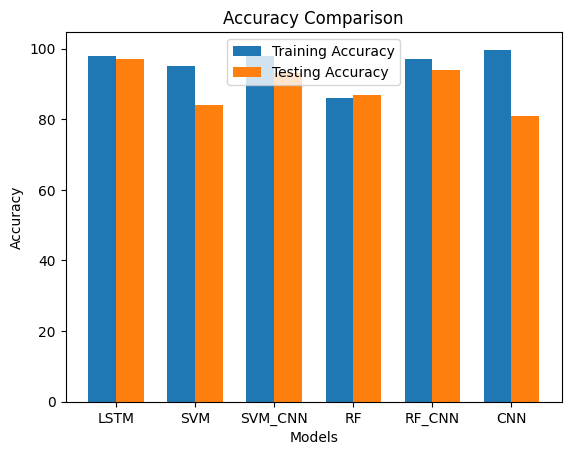

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
labels = ['LSTM', 'SVM', 'SVM_CNN', 'RF', 'RF_CNN', 'CNN']
accuracy_values = [[98, 97], [95, 84], [98,93], [86, 87], [97, 94], [99.7, 81]]

accuracy_values1 = [item[0] for item in accuracy_values]
accuracy_values2 = [item[1] for item in accuracy_values]

bar_width = 0.35
index = np.arange(len(labels))

fig, ax = plt.subplots()
bar1 = ax.bar(index, accuracy_values1, bar_width, label='Training Accuracy')
bar2 = ax.bar(index + bar_width, accuracy_values2, bar_width, label='Testing Accuracy')

ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy Comparison')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(labels)
ax.legend()

plt.show()
